# Ch 6. Mixture Models

1. Finite mixture models
2. Infinite mixture models
3. Continuous mixture models

In [6]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from scipy import stats

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

## Mixture models (MM)

- occurs when the population is a combination of sub-populations
- do not really have to believe there are sub-populations
    - can be used as a trick to add flexibility to the model

## Finite mixture models

- a finite weighted mixture of two or more distributions
- the probability density of the observed data is a weighted sum of the probability density for $K$ subgroups
    - $w_i$: wieght of each subgroup (a.k.a component)
    - $\Pr(y|\theta)_i$: distribution of the subgroup $i$

$$
\Pr(y|\theta) = \sum_{i=1}^{K} w_i \Pr_i(y | \theta_i)
$$

- to solve a MM, need to properly assign each data point to one of the components
    - introduce a random variable $z$ that specifies to which component an observation belongs
        - called a *latent* variable
- example using chemical shift data (from protein NMR)

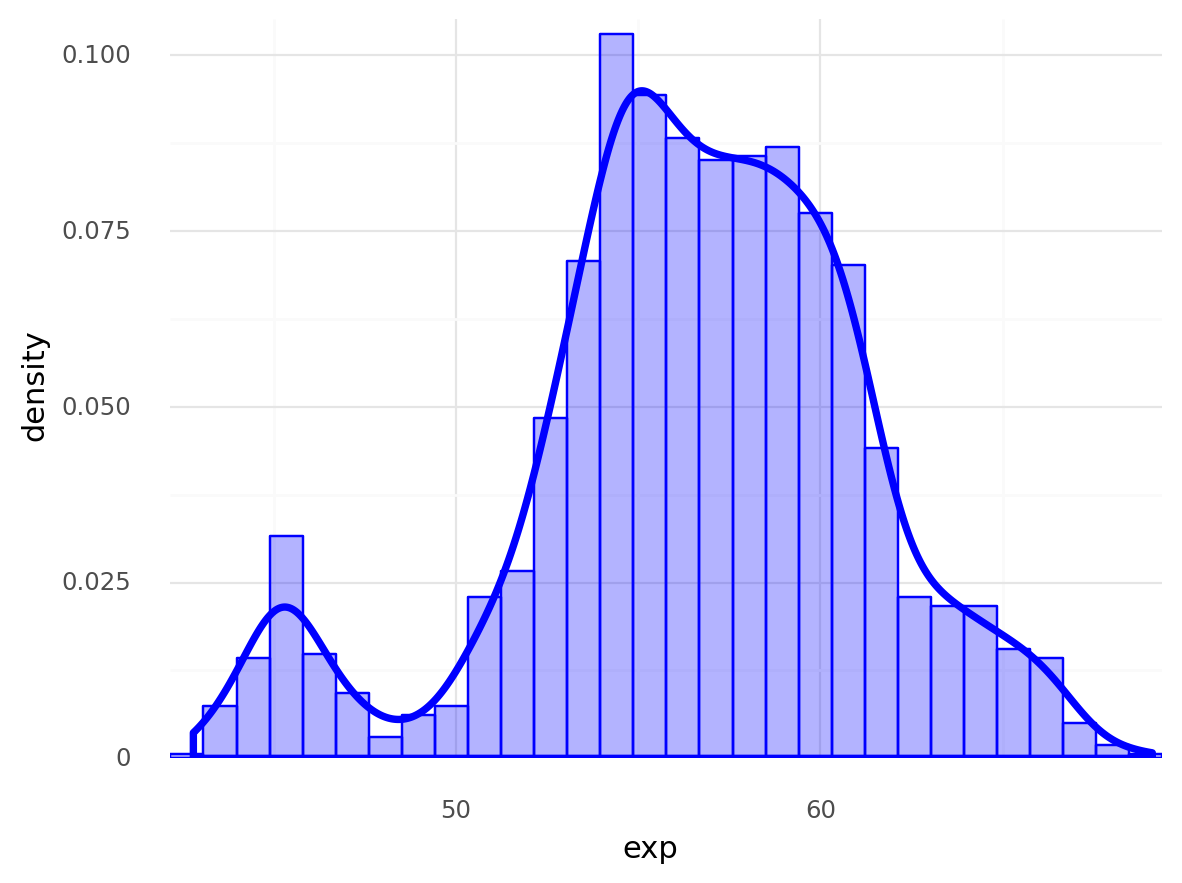

<ggplot: (8793033785432)>

In [7]:
cs = pd.read_csv(Path("data/chemical_shifts_theo_exp.csv"))
cs_exp = cs["exp"]

(
    gg.ggplot(cs, gg.aes("exp"))
    + gg.geom_histogram(
        gg.aes(y="..density.."), bins=30, alpha=0.3, fill="blue", color="blue"
    )
    + gg.geom_density(color="blue", size=1.5)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
)

### The categorical distribution

- most general discrete distribution
- parameterized using a parameter specifying the probabilities of each possible outcome

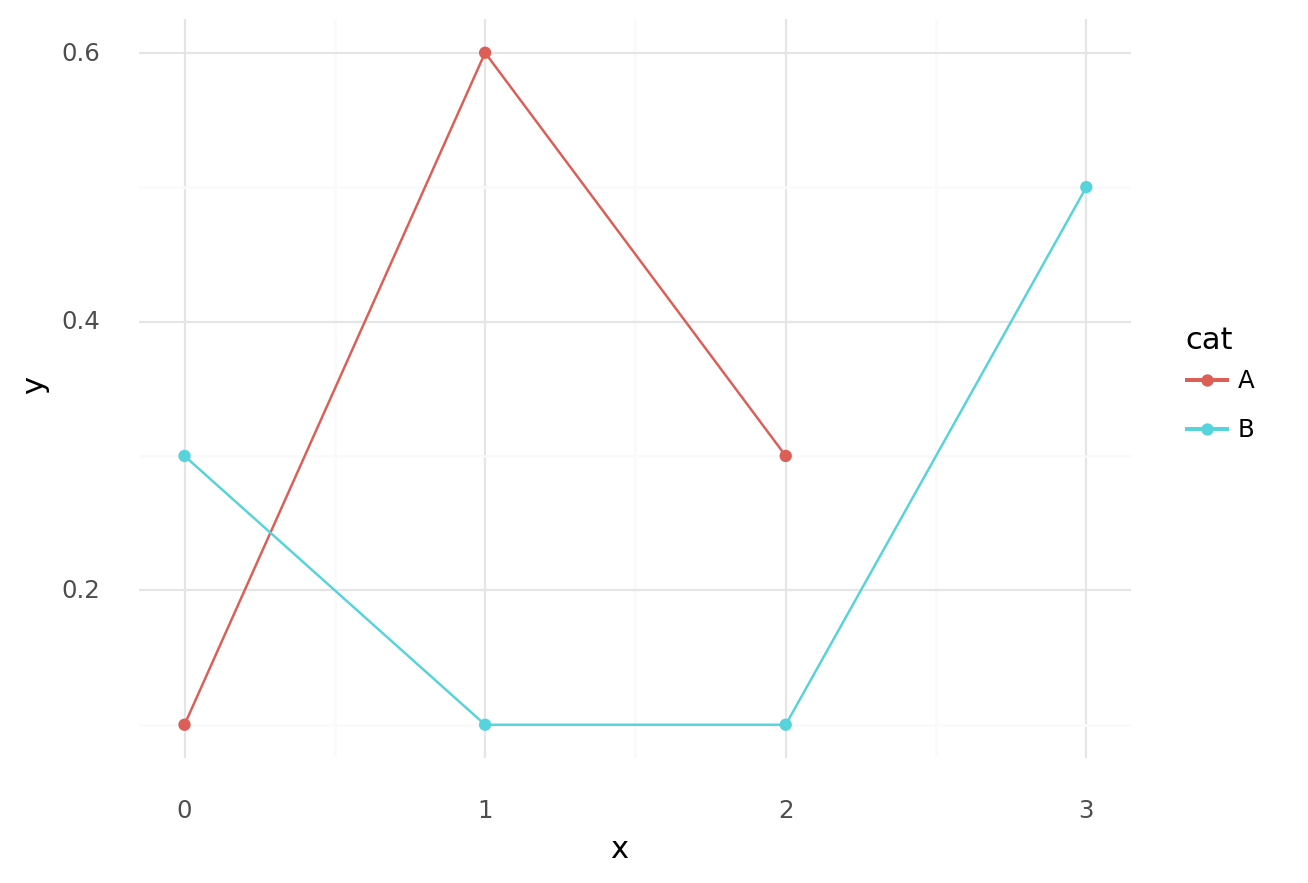

<ggplot: (8793037367209)>

In [8]:
example_cat_data = pd.DataFrame(
    {
        "cat": ["A", "A", "A", "B", "B", "B", "B"],
        "y": [0.1, 0.6, 0.3, 0.3, 0.1, 0.1, 0.5],
        "x": [0, 1, 2, 0, 1, 2, 3],
    }
)

(
    gg.ggplot(example_cat_data, gg.aes(x="x", y="y", color="cat"))
    + gg.geom_line()
    + gg.geom_point()
)

### The Dirichlet distribution

- the Dirichlet distribution:
    - lives in the *simplex* (an $n$-dim. triangle)
    - output of the dist. is a $K$-length vector $\alpha$
    - output are restricted to be 0 or larger and sum to 1
    - generalization of the beta distribution
        - i.e. extend the beta dist. beyond 2 outcomes

![](assets/ch06/Dirichlet-triangles.png)

- in a model, use the Dirichlet dist. as a $K$-sided coin flip model on top of a Gaussian estimated model
    - $\mu_k$ is dependent upon the group $k$
    - $\sigma_\mu$ and $\sigma_\sigma$ are shared for all groups

![](assets/ch06/Dirichlet-prior-mixture-model.png)

In [9]:
# NOTE: We expect this  model to fit poorly.
# See below for an example of how to reparameterize for a more
# effective fitting process.

clusters = 2

with pm.Model() as model_kg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    z = pm.Categorical("z", p=p, shape=len(cs.exp))
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.Normal("y", mu=means[z], sd=sd, observed=cs.exp)
    # trace_kg = pm.sample()  # NOT RUN BECAUSE TOOOOOOO SLOW

- the above model fits poorly because the latent variable `z` is explcitly included
- reparameterize:
    - in a MM, the observed vairable $y$ is conditional on the latent variable $z$: $\Pr(y|z, \theta)$
    - can consider $z$ is nuisance variable and marginalize to get $\Pr(y | \theta)$
    - can do this in PyMC3 using the `NormalMixture()` distribution to get a Gaussian mixture model

In [10]:
clusters = 2

with pm.Model() as model_mg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs.exp)

    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
az_trace_mg = az.from_pymc3(trace_mg, model=model_mg)

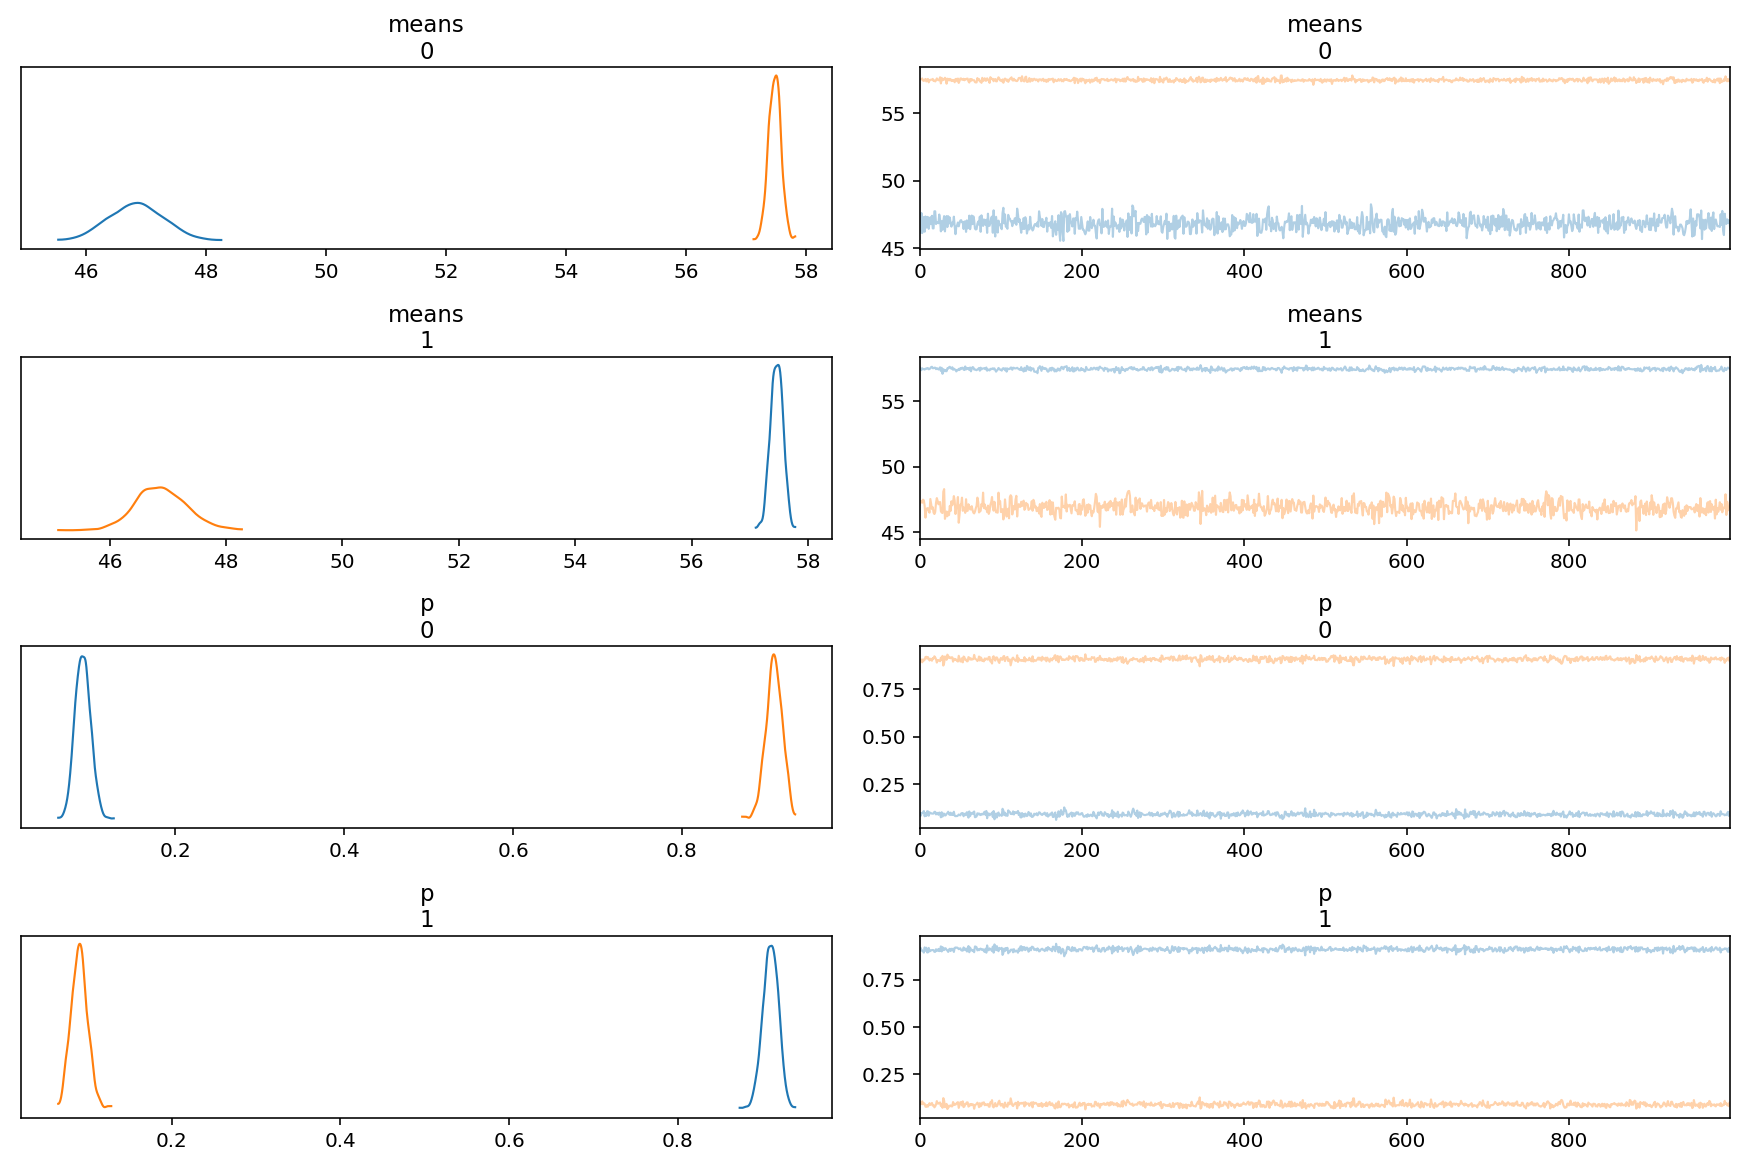

In [12]:
az.plot_trace(az_trace_mg, var_names=["means", "p"])
plt.show()

In [13]:
az.summary(trace_mg, var_names=["means", "p"])

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],52.154,5.329,46.242,57.681,3.747,3.169,2.0,2.0,3.0,63.0,1.83
means[1],52.174,5.299,46.358,57.664,3.726,3.152,2.0,2.0,3.0,61.0,1.83
p[0],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83
p[1],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83


### Non-identifiability of mixture models

---

In [14]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-04

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

arviz     : 0.10.0
pymc3     : 3.9.3
plotnine  : 0.7.1
matplotlib: 3.3.3
seaborn   : 0.11.1
numpy     : 1.19.4
scipy     : 1.6.0
pandas    : 1.2.0

